# Visualising a full Climate Data Record of multi-sensor Aerosol data

This second notebook extends the practical introduction of the first notebook to the 
[C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)
dataset.

Now, we create a full Climate Data Record from 1995 to 2023. This can only be achieved by combining shorter data record pieces from subsequent similar sensors. 

We start by downloading the data from the Climate Data Store (CDS) and then demonstrate three use cases for monthly mean multi-sensor data records: calculate and plot a regional data record, calculate and plot a regional multi-annual mean ("climatology") and plot a regional anomaly time series.

### How to access the notebook

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). You will not need to install any software for the training as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

|Binder|Kaggle|Colab|NBViewer|
|:-:|:-:|:-:|:-:|
|[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/C3S_climate-data-store.ipynb)|[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training/blob/master/C3S_climate-data-store.ipynb)|[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-projects/copernicus-training/blob/master/C3S_climate-data-store)|[![NBViewer](https://raw.githubusercontent.com/ecmwf-projects/copernicus-training/master/img/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/ecmwf-projects/copernicus-training/blob/master/C3S_climate-data-store.ipynb)|
|(Binder may take some time to load, so please be patient!)|(will need to login/register, and switch on the internet via *settings*)|(will need to run the command `!pip install cartopy` before importing the libraries)|(this will not run the notebook, only render it)|

If you would like to run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which contains most of the libraries you will need. You will also need to install  the CDS API (`pip install cdsapi`) for downloading data in batch mode from the CDS.

# <a id='intro'></a> Introduction

This second notebook focuses on combining subsequent parts of a long term record from a sequence of similar sensors, so that a relevant Climate Data Record (covering at least three decades) can be provided.

We combine now three AOD data records from three similar dual-view radiometers ATSR-2 (Along Track Scanning Radiometer no. 2), AATSR (Advanced ATSR) and SLSTR (Sea and Land Surface Temperature Radiometer). This can be done since all three instruments use the same measurement principle (conical scan which enables observing the Earth surface with two viewing directions: nadir and oblique) and have the same  set of seven visual and infrared channels. However, there are remaining differences between the instruments in data rates / sampling and most importantly, the pointing direction of the oblique view (forward for ATSR-2 and AATSR, rearward for SLSTR).

A user should be aware that slower long-term changes of atmospheric aerosols can only be seen in records of several decades while exceptionally large episodic extreme events may be visible in short records of a few years only.

### <a id='data_description'></a> Data description

<div style="text-align: justify"> The variable analysed by this dataset is meant to cover the global atmospheric aerosol distribution: aerosol optical depth (total abundance). AOD is here derived from observations from several dual view radiometers using different algorithms with specific strengths and weaknesses. The datasets originate from the same sensors but are processed by different algorithms to provide a way to evaluate uncertainties (e.g. areas of good or bad agreement between them). The notebook can also be applied to Fine-Mode AOD (particles with diameter smaller than 1 micron). </div>

The data are provided in netCDF format.

Please find further information about the dataset as well as the data in the Climate Data Store catalogue entry Aerosol properties, sections "Overview", "Download data" and "Documentation": 
- [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)

There in the "Documentation" part, one can find the Product User Guide and Specifications (PUGS) and the Algorithm Theoretical Baseline (ATBD) for further information on the different algorithms.

#### Import libraries

We will be working with data in NetCDF format. 

To best handle this data we will use the netCDF4 python library. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it: <br>

In [19]:
#!pip install cdsapi

In [20]:
# Import libraries needed for the Jupyter notebook

%matplotlib inline

# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import xarray as xr

# Library to work with zip-archives, OS-functions and pattern expansion
import zipfile
import os
from pathlib import Path

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib as mplt
import matplotlib.dates as md
import cartopy.crs as ccrs
import datetime

# Libraries for style parameters
from pylab import rcParams
import seaborn

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

In [21]:
# The following style parameters will be used for all plots in this use case.
rcParams['figure.figsize'] = [15, 5]
rcParams['figure.dpi'] = 350
rcParams['font.family'] =  'serif'
rcParams['font.serif']  =  mplt.rcParamsDefault['font.serif']
rcParams['mathtext.default'] = 'regular'
rcParams['mathtext.rm'] = 'serif:light'
rcParams['mathtext.it'] = 'serif:italic'
rcParams['mathtext.bf'] = 'serif:bold'
plt.rc('font', size=17)          # controls default text sizes
plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=17)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

projection=ccrs.PlateCarree()
mplt.rc('xtick', labelsize=9) 
mplt.rc('ytick', labelsize=9)

# <a id='cdsapi'></a> Download data using CDS API

### CDS API credentials

<div style="text-align: justify"> We will request data from the Climate Data Store (CDS): https://cds.climate.copernicus.eu/cdsapp#!/home. In case you don't have an account yet, please click on "Login/register" at the right top and select "Create new account". With the process finished you are able to login to the CDS and can search for your preferred data.</div>

We will request data from the CDS in batch mode with the help of the CDS API. 
First, we need to manually set the CDS API credentials. 
To do so, we need to define two variables: URL and KEY. 
To obtain these, first login to the CDS, then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with this string.


In [22]:
# Specify the CDS path for data access and your personal access key

URL = 'https://cds.climate.copernicus.eu/api'
KEY = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

Next, we specify a data directory in which we will download our data and all output files that we will generate:

In [23]:
# Specify local data directories for the downloads and the plot files

DATADIR='./test_long/'
if not os.path.exists(DATADIR):
    os.mkdir(DATADIR)

# Long Time Series

To start, we need to define the variable, algorithm and region for our analysis. Furthermore, latest dataset versions for each Dual view algorithm are specified.

In [24]:
# Define the data record which shall be downloaded and visualized: variable, algorithm, region, years

variable = 'aerosol_optical_depth'
algorithm = 'SWANSEA'
region = 'Europe'
years = ['%04d'%(yea) for yea in range(1995, 2024)]


In [25]:
# Define versions of the 4 available algorithms per sensor

version_ATSR2 = {'ORAC': 'v4_02',
                'ADV': 'v4_1',
                'SWANSEA': 'v4_33',
                'ENS': 'v3_1',}
version_AATSR = {'ORAC': 'v4_02',
                'ADV': 'v4_1',
                'SWANSEA': 'v4_33',
                'ENS': 'v3_1',}
version_SLSTR = {'ORAC': 'v1_00',
                'SDV': 'v2_30',
                'SWANSEA': 'v1_12',
                'ENS': 'v2_3',}

Next, we implement definitions of some relevant regions, define the temporal coverage for each instrument in the sensor series and extract cell indices for the selected region.

In [26]:
# Definition of different regions to choose from

extent = { # 'Region' : [lon_min, lon_max, lat_min, lat_max],
            'Europe': [-15, 50, 36, 60],
            'Boreal': [-180, 180, 60, 85],
            'Asia_North': [50, 165, 40, 60],
            'Asia_East': [100, 130, 5, 41],
            'Asia_West': [50, 100, 5, 41],
            'China_South-East': [103, 135, 20, 41],
            'Australia': [100, 155, -45, -10],
            'Africa_North': [-17, 50, 12, 36], 
            'Africa_South': [-17, 50, -35, -12],
            'South_America': [-82, -35, -55, 5],
            'North_America_West': [-135, -100, 13, 60],
            'North_America_East': [-100, -55, 13, 60],
            'Indonesia': [90, 165, -10, 5],
            'Atlanti_Ocean_dust': [-47, -17, 5, 30],
            'Atlantic_Ocean_biomass_burnig': [-17, 9, -30, 5],
            'World': [-180, 180, -90, 90],
            'Asia': [50, 165, 5, 60],
            'North_America': [-135, -55, 13, 60], 
            'dust_belt': [-80, 120, 0, 40], 
            'India': [70, 90, 8, 32], 
            'Northern_Hemisphere': [-180, 180, 0, 90], 
            'Southern_Hemisphere': [-180, 180, -90, 0],
            }

In [27]:
# Definition of available years per sensor and the combined data record

years_ATSR2 = ['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002']
years_AATSR = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011']
years_SLSTR = ['2017', '2018', '2019', '2020', '2021', '2022','2023']  
years_dual = years_ATSR2 + years_AATSR + years_SLSTR
months = ['%02d'%(mnth) for mnth in range(1,13)]

# <a id='cdsapi'></a> Download data using CDS API

Then we prepare and start the CDS download.

To search for data, visit the CDS website: https://cds.climate.copernicus.eu/cdsapp#!/home.
Here you can search for aerosol data using the search bar. The data we need for this use case is the [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview).

In [10]:
# Define the API for the CDS access

c = cdsapi.Client(url=URL, key=KEY)
product='satellite-aerosol-properties'

2024-11-07 09:09:21,567 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-07 09:09:21,568 WARNING [2024-09-26T00:00:00] Should you have not yet migrated from the old CDS system to the new CDS, please check our [informative page](https://confluence.ecmwf.int/x/uINmFw) for guidance.
2024-11-07 09:09:21,568 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-07 09:09:21,569 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-07 09:09:21,569 WARNING [2024-06-16T

We now download the full time record of one dual view algorithm 1995 - 2022:
The following download may take ~ 15 min (exact time needed depends on your network and hardware).
Do not worry, as there may be many error messages for missing months in gaps.

In [16]:
# Run the following code lines to automatically replace algorithm names specifically per sensor (ADV / SDV only)

for year in years:
    if year in years_ATSR2:
        Instrument = 'atsr2_on_ers2'           
        if algorithm == 'ADV/SDV':
            algorithm = 'ADV'
        version = version_ATSR2[algorithm] 
    elif year in years_AATSR:
        Instrument = 'aatsr_on_envisat'
        if algorithm == 'ADV/SDV':
            algorithm = 'ADV'
        version = version_AATSR[algorithm]
    elif year in years_SLSTR:
        Instrument = 'slstr_on_sentinel_3a'
        if algorithm == 'ADV/SDV' or algorithm == 'ADV':
            algorithm = 'SDV'
        version = version_SLSTR[algorithm]  
    
    # Retrieve the datasets from the CDS

    for month in months:
        if year in years_dual:
            try:
                request = {
                        'time_aggregation': 'monthly_average',
                        'variable': variable,
                        'sensor_on_satellite': Instrument,
                        'algorithm': algorithm.lower(),
                        'year': year, 
                        'month': month,
                        'version': version}
                file_name = DATADIR + algorithm + '_' + str(year) + '_' + str(month) + '.zip'
                c.retrieve(product, request, file_name)
                print('downloaded ' + year + '-' + month)
            except:
                print('no data ' + year + '-' + month)



['2022', '2023']
['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2022', '2023']


2024-11-07 14:46:00,481 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:46:00,482 INFO Request ID is 7b08e183-5c30-411b-9281-9aa512369fec
2024-11-07 14:46:01,662 INFO status has been updated to accepted
2024-11-07 14:46:06,711 INFO status has been updated to running
2024-11-07 14:46:10,157 INFO status has been updated to successful


downloaded 2022-01


2024-11-07 14:46:11,579 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:46:11,580 INFO Request ID is ad608b32-0fa8-407c-bb2f-fd0f6040ae9e
2024-11-07 14:46:11,632 INFO status has been updated to accepted
2024-11-07 14:46:17,288 INFO status has been updated to running
2024-11-07 14:46:20,721 INFO status has been updated to successful


downloaded 2022-02


2024-11-07 14:46:22,740 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:46:22,741 INFO Request ID is 44e57bb8-8fc7-4b56-8c06-514faaae9b8a
2024-11-07 14:46:22,813 INFO status has been updated to accepted
2024-11-07 14:46:27,738 INFO status has been updated to running
2024-11-07 14:46:31,168 INFO status has been updated to successful


downloaded 2022-03


2024-11-07 14:46:32,343 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:46:32,344 INFO Request ID is 01bd6099-1010-4754-9aba-860eb95fbdf2
2024-11-07 14:46:32,515 INFO status has been updated to accepted
2024-11-07 14:46:37,928 INFO status has been updated to running
2024-11-07 14:46:41,681 INFO status has been updated to successful


downloaded 2022-04


2024-11-07 14:46:44,353 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:46:44,354 INFO Request ID is d47e6916-d03c-4bdd-aad1-9429fb14f5ce
2024-11-07 14:46:44,406 INFO status has been updated to accepted
2024-11-07 14:46:50,884 INFO status has been updated to running
2024-11-07 14:47:00,087 INFO status has been updated to successful


downloaded 2022-05


2024-11-07 14:47:01,346 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:47:01,347 INFO Request ID is d8226b55-6c8d-4d69-a913-5fb413e31bf1
2024-11-07 14:47:01,401 INFO status has been updated to accepted
2024-11-07 14:47:06,337 INFO status has been updated to running
2024-11-07 14:47:09,762 INFO status has been updated to successful


downloaded 2022-06


2024-11-07 14:47:11,578 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:47:11,579 INFO Request ID is da6abffd-245c-41ff-8b20-2289cdb3fc95
2024-11-07 14:47:11,641 INFO status has been updated to accepted
2024-11-07 14:47:14,995 INFO status has been updated to running
2024-11-07 14:47:20,754 INFO status has been updated to successful


downloaded 2022-07


2024-11-07 14:47:21,873 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:47:21,874 INFO Request ID is 52420b31-f785-4edc-a2ab-7fb404481bc4
2024-11-07 14:47:22,065 INFO status has been updated to accepted
2024-11-07 14:47:27,367 INFO status has been updated to running
2024-11-07 14:47:30,803 INFO status has been updated to successful


downloaded 2022-08


2024-11-07 14:47:32,108 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:47:32,109 INFO Request ID is 653e1672-47ac-47e3-add0-cfabc99dc268
2024-11-07 14:47:32,166 INFO status has been updated to accepted
2024-11-07 14:47:40,569 INFO status has been updated to successful


downloaded 2022-09


2024-11-07 14:47:43,229 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:47:43,230 INFO Request ID is 3e3bae32-b3f6-4667-a224-dcec1a666d4a
2024-11-07 14:47:43,286 INFO status has been updated to accepted
2024-11-07 14:47:57,803 INFO status has been updated to successful


downloaded 2022-10


2024-11-07 14:47:59,281 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:47:59,282 INFO Request ID is a9715988-5300-460b-8631-355e36ae10b9
2024-11-07 14:47:59,386 INFO status has been updated to accepted
2024-11-07 14:48:04,335 INFO status has been updated to running
2024-11-07 14:48:07,779 INFO status has been updated to successful


downloaded 2022-11


2024-11-07 14:48:09,067 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:48:09,067 INFO Request ID is c3f1869d-95cf-4564-a1d2-0022ba95d5c2
2024-11-07 14:48:09,141 INFO status has been updated to accepted
2024-11-07 14:48:17,622 INFO status has been updated to running
2024-11-07 14:48:22,772 INFO status has been updated to successful


downloaded 2022-12


2024-11-07 14:48:24,082 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:48:24,083 INFO Request ID is 0f2fb8f8-4bfd-4d62-99ae-8ca7ca8a80a5
2024-11-07 14:48:24,139 INFO status has been updated to accepted
2024-11-07 14:48:29,079 INFO status has been updated to running
2024-11-07 14:48:37,655 INFO status has been updated to successful


downloaded 2023-01


2024-11-07 14:48:39,429 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:48:39,430 INFO Request ID is 76a4df8a-d146-4c9a-9b0d-1674780ff124
2024-11-07 14:48:39,492 INFO status has been updated to accepted
2024-11-07 14:48:43,429 INFO status has been updated to running
2024-11-07 14:48:45,781 INFO status has been updated to accepted
2024-11-07 14:48:54,503 INFO status has been updated to successful


downloaded 2023-02


2024-11-07 14:48:55,948 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:48:55,949 INFO Request ID is 9ce50413-5c66-4cf2-a18a-71285fd040dd
2024-11-07 14:48:56,003 INFO status has been updated to accepted
2024-11-07 14:49:00,901 INFO status has been updated to running
2024-11-07 14:49:09,451 INFO status has been updated to successful


downloaded 2023-03


2024-11-07 14:49:10,724 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:49:10,725 INFO Request ID is 2bc39bfa-1a5b-4575-a6be-c2a334530035
2024-11-07 14:49:10,779 INFO status has been updated to accepted
2024-11-07 14:49:16,165 INFO status has been updated to running
2024-11-07 14:49:19,749 INFO status has been updated to accepted
2024-11-07 14:49:25,003 INFO status has been updated to successful


downloaded 2023-04


2024-11-07 14:49:27,516 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:49:27,517 INFO Request ID is c4c11f6a-5710-4bfc-8536-944a0cebd7f3
2024-11-07 14:49:27,569 INFO status has been updated to accepted
2024-11-07 14:49:32,513 INFO status has been updated to running
2024-11-07 14:49:36,190 INFO status has been updated to accepted
2024-11-07 14:49:41,314 INFO status has been updated to successful


downloaded 2023-05


2024-11-07 14:49:43,270 INFO [2022-04-01T00:00:00] GOMOS on ENVISAT version 5.00 data have been deprecated. Consult Known Issues in the Documentation tab.
2024-11-07 14:49:43,271 INFO Request ID is f71178a9-6aa2-4c4b-b343-62b600b9dea4
2024-11-07 14:49:43,400 INFO status has been updated to accepted
2024-11-07 14:49:51,934 INFO status has been updated to running
2024-11-07 14:49:57,054 INFO status has been updated to successful


downloaded 2023-06
no data 2023-07
no data 2023-08
no data 2023-09
no data 2023-10
no data 2023-11
no data 2023-12


Next, we unpack the data.

In [28]:
# Unpack the downloaded data to a predefined sub directory for the selected dataset 
# (which can be used for future applications of the Jupyter notebook without repeating the download)

files = os.listdir(DATADIR)
dir = f'{DATADIR}' + 'data/'

for file in files:
    if '.zip' in file:
        with zipfile.ZipFile(DATADIR + file, 'r') as zip_ref:
            zip_ref.extractall(f'{DATADIR}' + 'data')
        os.remove(DATADIR + file)

files = os.listdir(dir)

Correction of variable names: There are a few variable naming inconsistencies which we automatically adjust by the following code block.

Those inconsistencies are remaining despite of strong format harmonization efforts from the fact that the algorithms / datasets come from different providers who have somewhat different coding practices.

In [29]:
# Run the following code lines to automatically replace all variable names which are inconsistent, so that you need not care any further

if variable == 'aerosol_optical_depth':
    if algorithm == 'ens':
        variable = 'AOD550'
    else:
        variable = 'AOD550_mean'
elif variable == 'fine_mode_aerosol_optical_depth':
    if algorithm == 'ens':
        variable = 'FM_AOD550'
    else:
        variable = 'FM_AOD550_mean'
elif variable == 'dust_aerosol_optical_depth':
    if algorithm == 'ens':
        variable = 'DAOD550'
    elif algorithm == 'lmd':
        variable = 'Daod550'
    elif algorithm == 'imars':
        variable = 'D_AOD550'
    else:
        variable = 'D_AOD550_mean'

# <a id='timeseries'></a> Use case 1: extract and plot long time series

Finally, we get the regional time series as a list. 

Since the validation showed a significant bias for SLSTR algorithms with some but limited regional variations, we have to subtract it before combining the time series. Note that we use a global average bias here, while a more sophisticated correction will use regional biases. The bias correction was determined by comparison to AOD data from the global sun photometer network AERONET.

In [36]:
# Define global bias corrections for SLSTR per algorithm

if algorithm == 'SWANSEA':
    slstr_bias = 0.045
if algorithm == 'ORAC':
    slstr_bias = 0.06
if algorithm == 'SDV':
    slstr_bias = 0.00
if algorithm == 'ENS':
    slstr_bias = 0.03

var = []
time = []

for year in years_dual:    
    for month in months:
        time_element = datetime.datetime.fromisoformat(year + '-' + month + '-15') 
        t = year + month
        len1 = len(var)
        time.append(time_element)
        try:
            for file in files:
                if t in file:
                    correct = 0 # no bias correction for ATSR-2 and AATSR
                    if file[35:40] == 'SLSTR':
                        correct = slstr_bias # SLSTR bias correction
                    dataset = xr.open_dataset(dir + file) # open each monthly dataset with xarray 
                    data = getattr(dataset, variable).sel(latitude=slice(extent[region][2], extent[region][3]), longitude=slice(extent[region][0], extent[region][1]))
                    var_data = float(data.mean(skipna = True)) - correct # apply the bias correction
                    var.append(var_data)
                    dataset.close()
        except:
            var.append(np.nan)
        if len1 == len(var):
            var.append(np.nan)



Here, we plot the long time series.

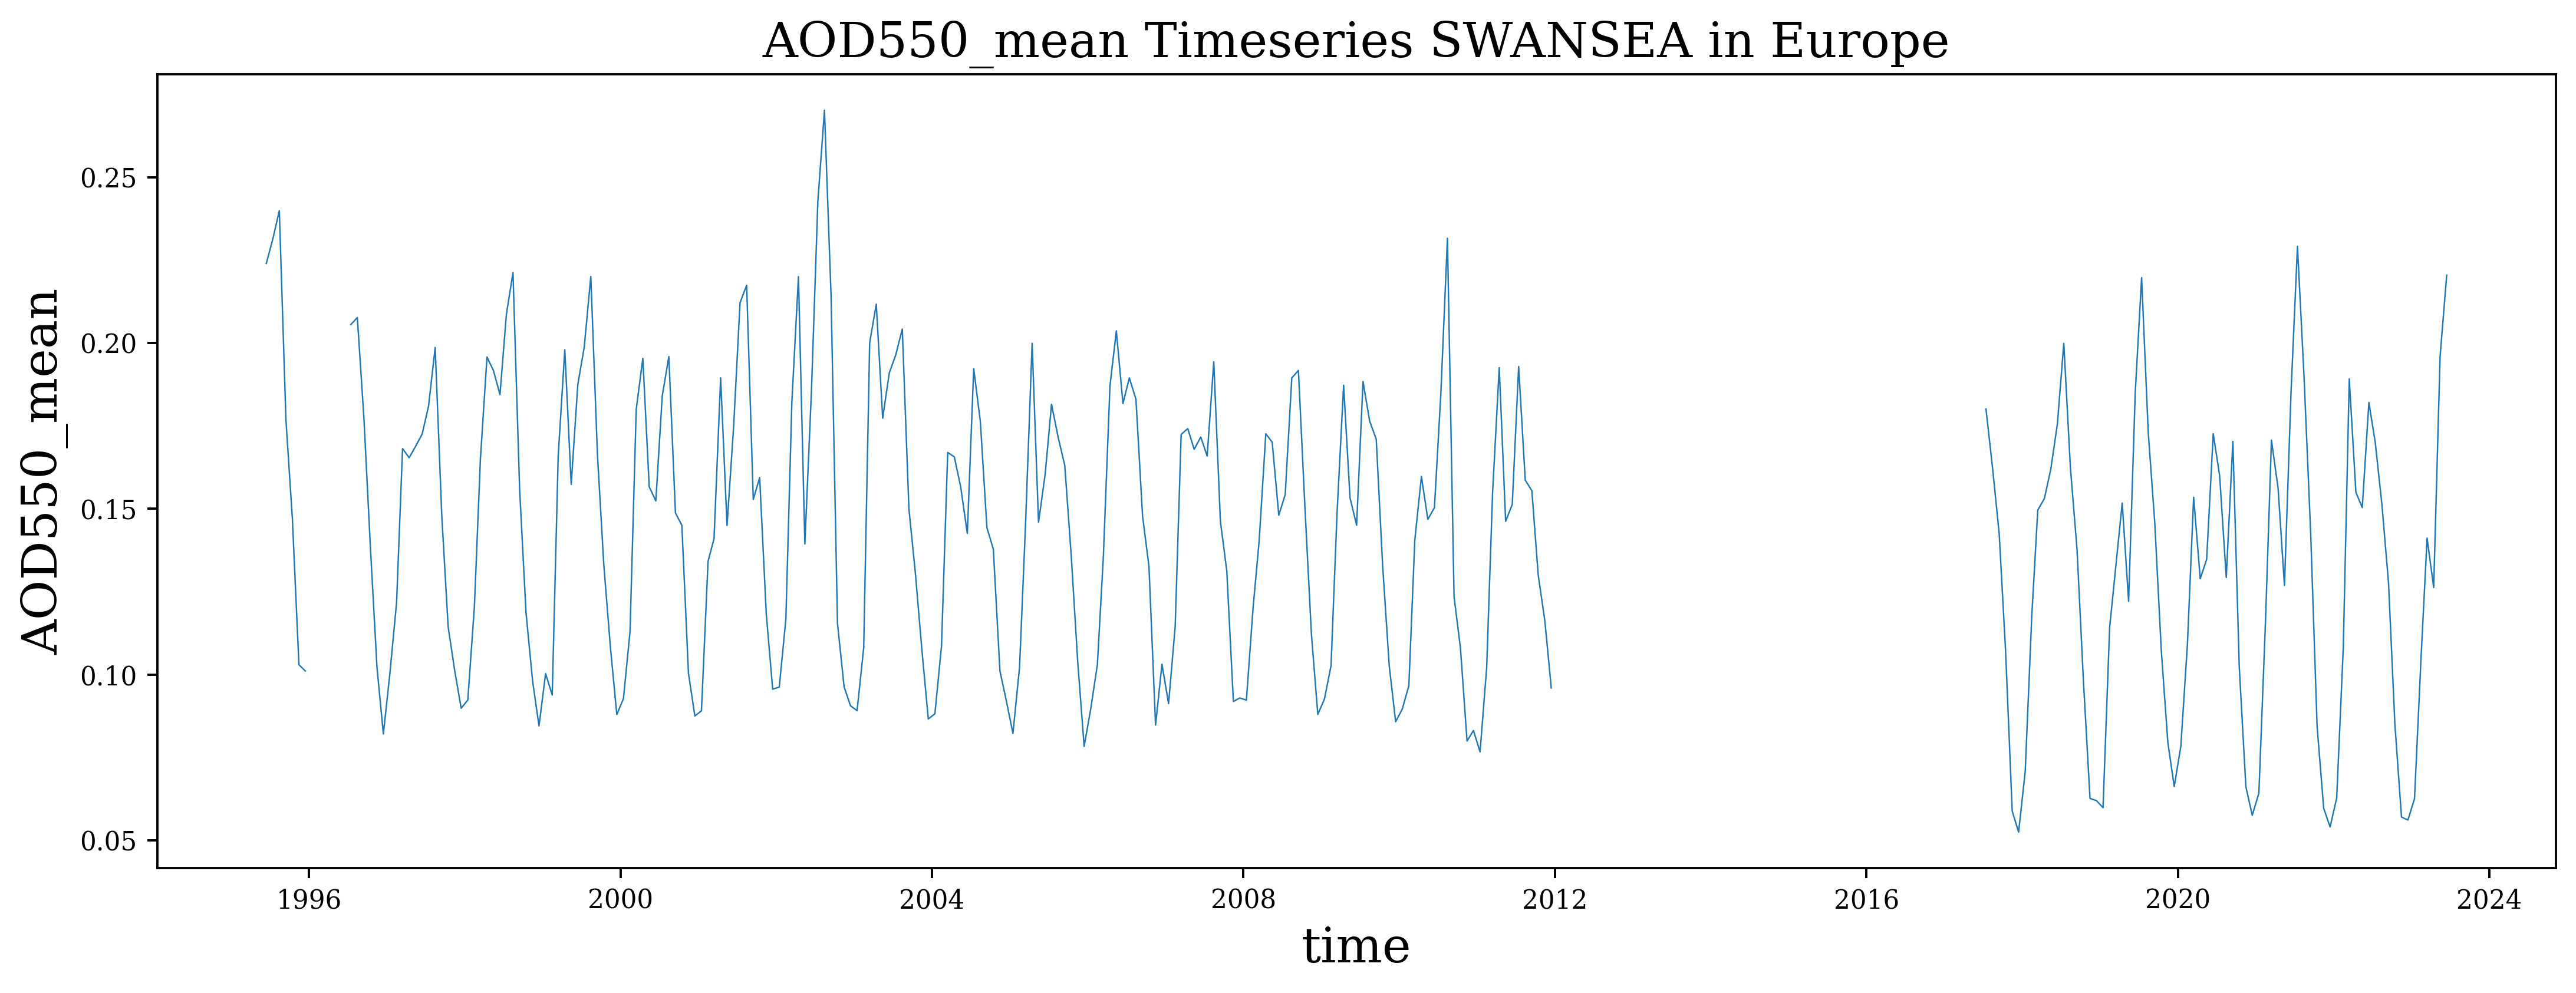

In [31]:
# Plot the combined data record

plt.plot(time, var, '-', label = variable, linewidth = 0.5)
plt.ylabel(variable)
plt.xlabel('time')
plt.title(variable + ' Timeseries ' + algorithm + ' in ' + region)
plt.savefig(DATADIR + 'timeseries_' + variable + '_' + algorithm + '_' + region + '.png', dpi=500, bbox_inches='tight')

**FIGURE 1:** This time series shows the long term behaviour of aerosol properties in the selected region. Note that a global bias correction was applied for the last part (SLSTR) which may be a bit too large for this region.

# <a id='climatology'></a> Use case 2: Calculate and plot a multi-annual mean ("climatology")

We calculate a multi-annual mean for each sensor in the time series, i.e. for ATSR-2 (1995-2002), AATSR (2003-2011) and SLSTR (2017-2022) and use each of them for the respective time series. We calculate the multi-annual means separately per sensor, since there is no overlap between AATSR and SLSTR which would allow a relative bias correction without extrapolation.

In [32]:
## Climatology     
aod_standard_deviation_ges = []
aod_climatology_ges = []

#ATSR2                              
aod_standard_deviation1 = []
aod_climatology1 = []                            
for month in months: 
    aodmonth1 = []
    aodvar1 = []
    for year in years_ATSR2[2:]:
        t = year + month
        for file in files:
            if t in file:
                path = dir + file
                file = xr.open_dataset(path) # open dataset with xarray
                data = getattr(file, variable).sel(
                    latitude=slice(extent[region][2], extent[region][3]), 
                    longitude=slice(extent[region][0], extent[region][1]))
                data_mean = float(data.mean(skipna = True)) 
                data_var = (data_mean**2)/len(years_ATSR2[2:])
                aodmonth1.append(data_mean)
                aodvar1.append(data_var)
    expectation = sum(aodmonth1)/len(years_ATSR2[2:])    
    standard_deviation = np.sqrt(sum(aodvar1)-expectation**2) 
    aod_climatology1.append(expectation)
    aod_standard_deviation1.append(standard_deviation)
    
for i in range(len(years_ATSR2)):
    aod_climatology_ges.extend(aod_climatology1) 
    aod_standard_deviation_ges.extend(aod_standard_deviation1)   

#AATSR                              
aod_standard_deviation1 = []
aod_climatology1 = []                            
for month in months: 
    aodmonth1 = []
    aodvar1 = []
    for year in years_AATSR:
        t = year + month
        for file in files:
            if t in file:
                path = dir + file 
                file = xr.open_dataset(path)
                data = getattr(file, variable).sel(
                    latitude=slice(extent[region][2], extent[region][3]), 
                    longitude=slice(extent[region][0], extent[region][1]))
                data_mean = float(data.mean(skipna = True))
                data_var = (data_mean**2)/len(years_AATSR)
                aodmonth1.append(data_mean)
                aodvar1.append(data_var)
    expectation = sum(aodmonth1)/len(years_AATSR)   
    standard_deviation = np.sqrt(sum(aodvar1)-expectation**2) 
    aod_climatology1.append(expectation)
    aod_standard_deviation1.append(standard_deviation)
    
for i in range(len(years_AATSR)):
    aod_climatology_ges.extend(aod_climatology1) 
    aod_standard_deviation_ges.extend(aod_standard_deviation1)   

#DATA GAP
nan_list = [np.nan for i in range(12)]
aod_climatology_ges.extend(nan_list) 
aod_standard_deviation_ges.extend(nan_list) 

#SLSTR                              
aod_standard_deviation1 = []
aod_climatology1 = []                            
for month in months: 
    aodmonth1 = []
    aodvar1 = []
    for year in years_SLSTR:
        t = year + month
        for file in files:
            if t in file:
                path = dir + file 
                file = xr.open_dataset(path)
                data = getattr(file, variable).sel(
                    latitude=slice(extent[region][2], extent[region][3]), 
                    longitude=slice(extent[region][0], extent[region][1]))
                data_mean = float(data.mean(skipna = True)) - correct
                data_var = (data_mean**2)/len(years_SLSTR)
                aodmonth1.append(data_mean)
                aodvar1.append(data_var)
    expectation = sum(aodmonth1)/len(years_SLSTR)  
    standard_deviation = np.sqrt(sum(aodvar1)-expectation**2) 
    aod_climatology1.append(expectation)
    aod_standard_deviation1.append(standard_deviation)
    
for i in range(len(years_SLSTR)):
    aod_climatology_ges.extend(aod_climatology1) 
    aod_standard_deviation_ges.extend(aod_standard_deviation1)   

aod_standard_deviation1 = [aod_climatology_ges[i] + aod_standard_deviation_ges[i] for i in range(len(aod_standard_deviation_ges))] 
aod_standard_deviation2 = [aod_climatology_ges[i] - aod_standard_deviation_ges[i] for i in range(len(aod_standard_deviation_ges))] 

years_dual = years_ATSR2 + years_AATSR + ['2016'] + years_SLSTR
time_dual = []
for year in years_dual:
    for month in months:
        t = year + '-' + month
        time_dual.append(datetime.datetime.fromisoformat(t + '-15'))
    

Now we plot the time series with the climatologies.

/tmp/ipykernel_1531130/1500953052.py:2: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(time, var, '-', label = variable, color = 'red', linewidth = 0.5)


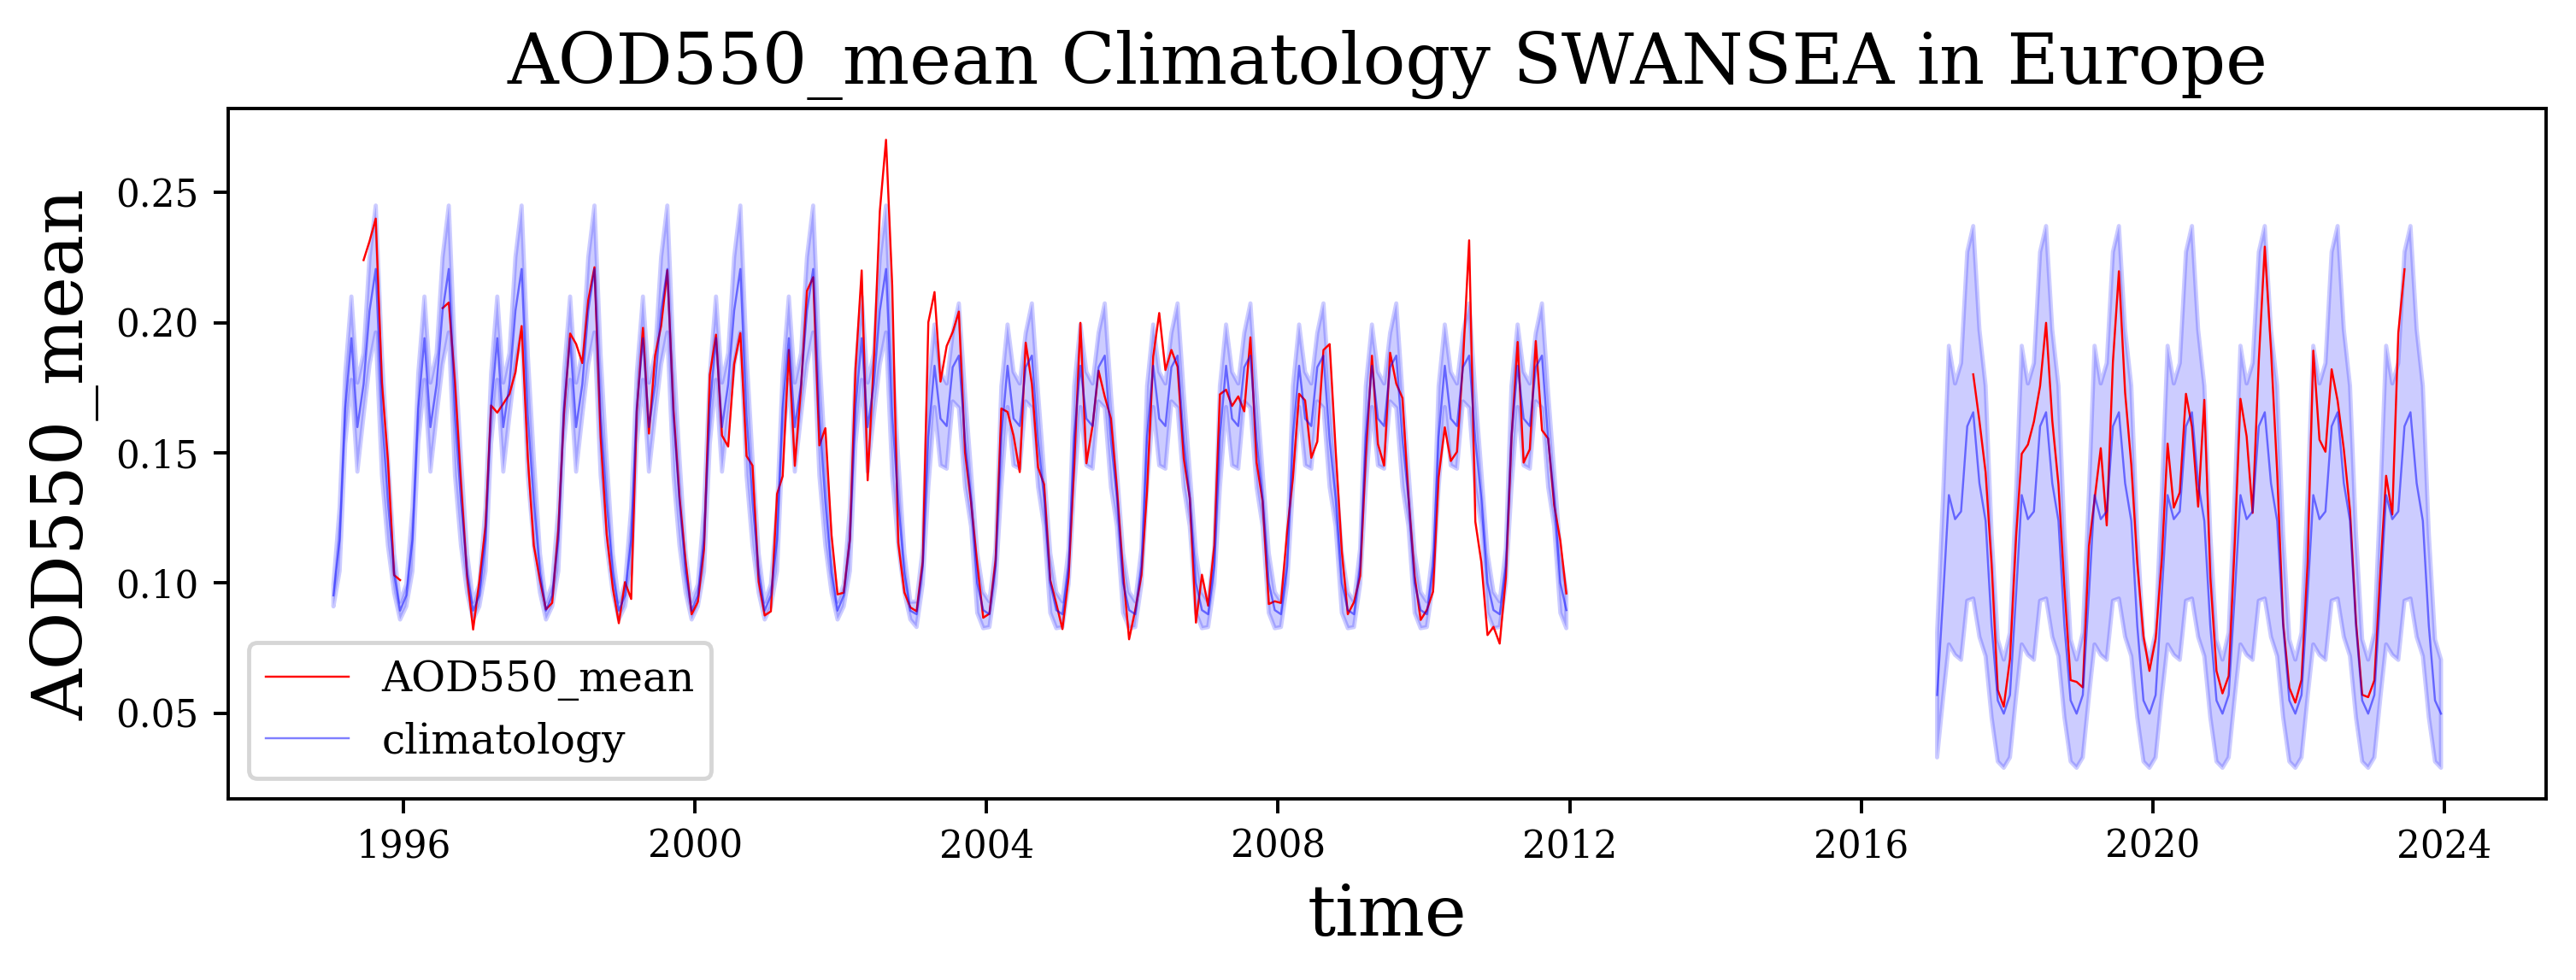

In [33]:
# Plot the time series overlayed with the annually repeated climatology

fig = plt.figure(figsize=(10,3))
plt.plot_date(time, var, '-', label = variable, color = 'red', linewidth = 0.5)    
plt.fill_between(time_dual, aod_standard_deviation1, aod_standard_deviation2, color = 'blue', alpha = 0.2)
plt.plot(time_dual, aod_climatology_ges, '-', label = 'climatology', color = 'blue', linewidth = 0.5, alpha = 0.5)
plt.ylabel(variable)
plt.xlabel('time')
plt.legend()
plt.title(variable + ' Climatology ' + algorithm + ' in ' + region)
plt.savefig(DATADIR + 'timeseries_with_climatology_' + variable + '_' + algorithm + '_' + region + '.png', dpi=500, bbox_inches='tight')


**FIGURE 2:** This time series plotted over repeated annual climatologies (per sensor) already indicates any episodic events outside the long-term variabiliy. Note that a global bias correction was applied for the last part (SLSTR) which may be a bit too large for this region.

# <a id='anomaly'></a> Use case 3: Calculate and plot the anomaly time series

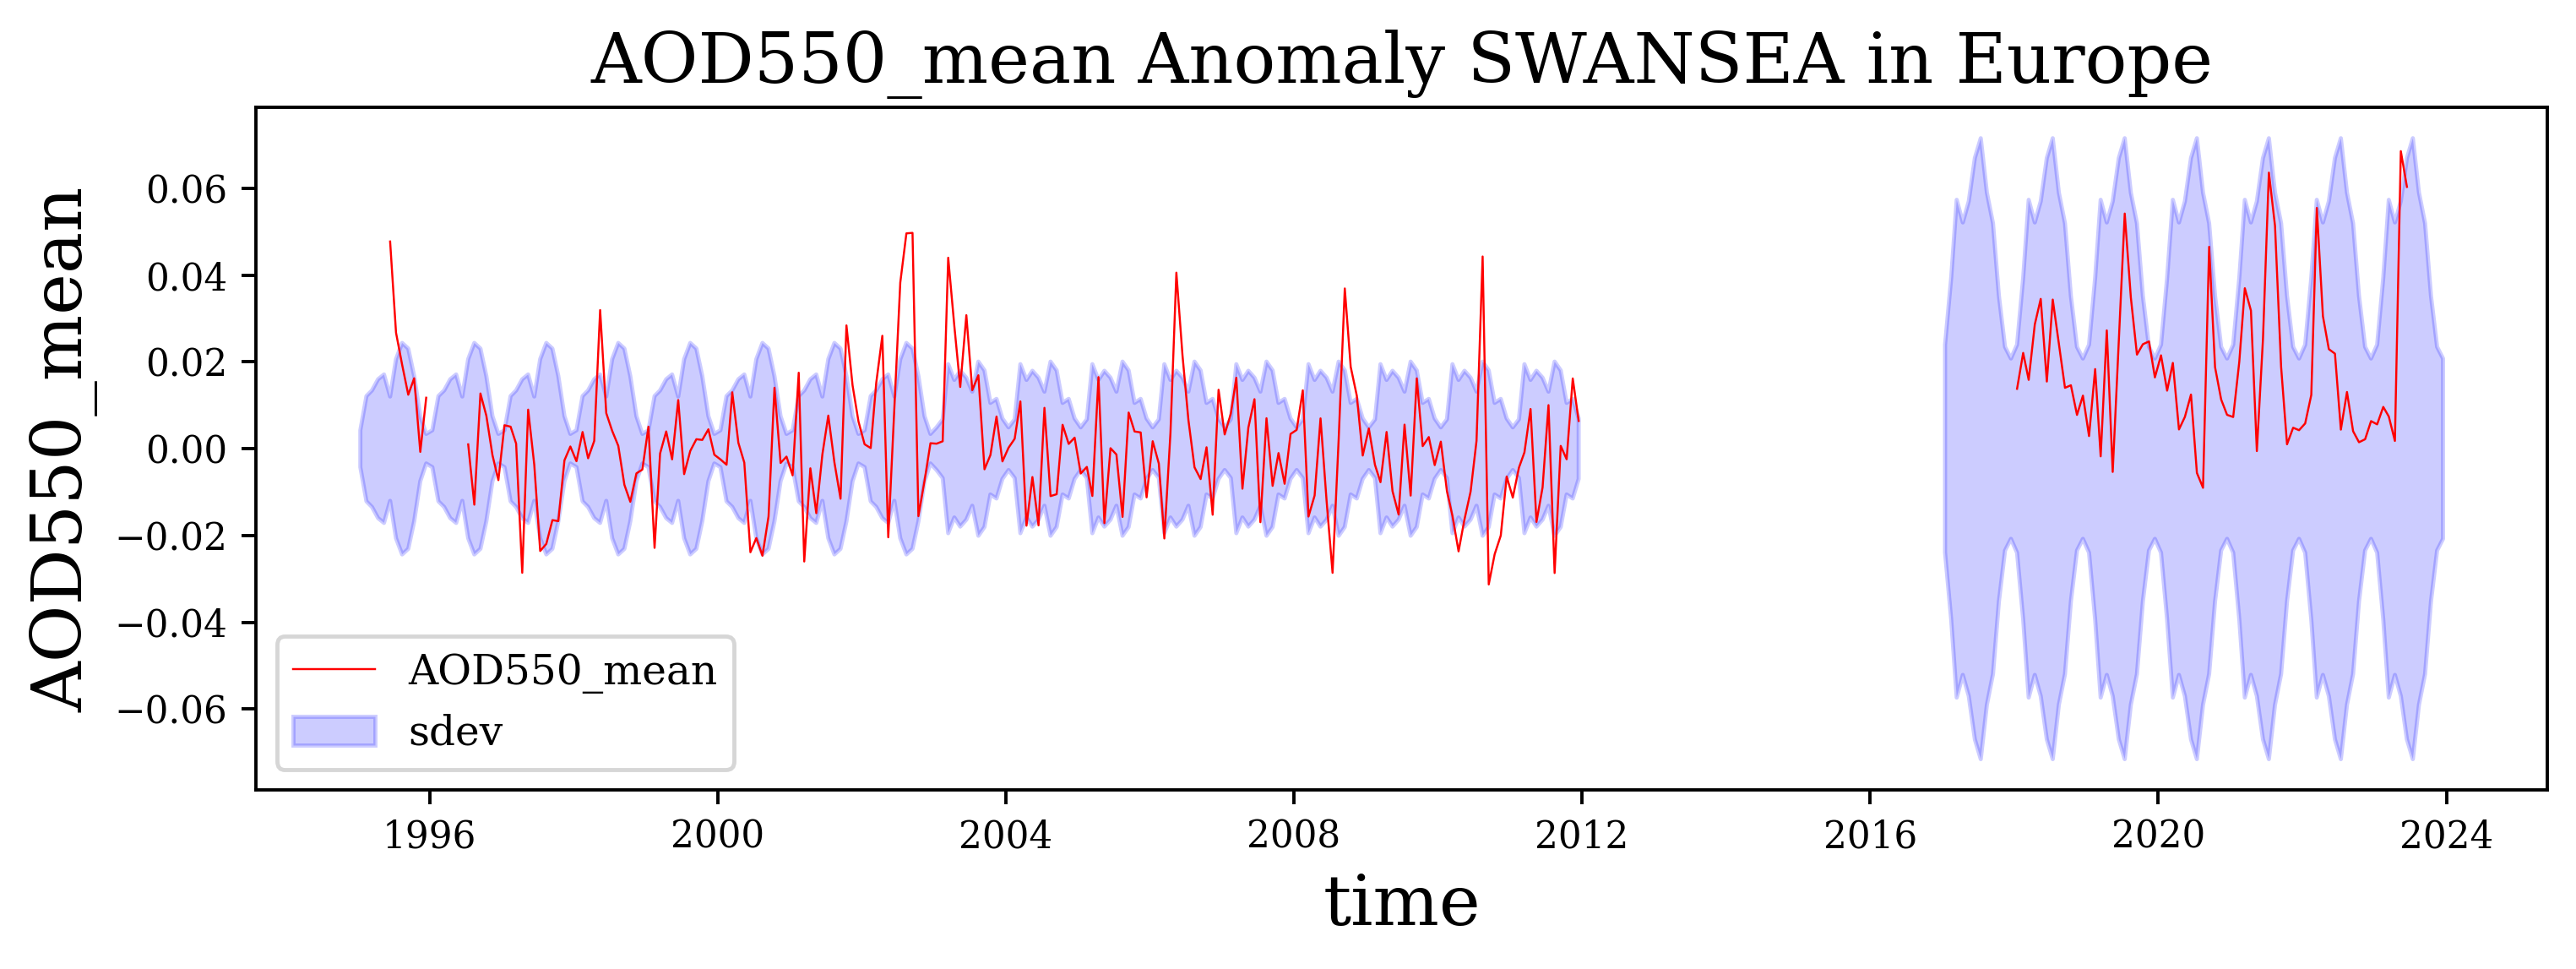

In [34]:
# Calculate anomalies := difference of individual value and cliamtology value for each month

anomaly = [var[i] - aod_climatology_ges[i] for i in range(len(var))]
aod_standard_deviation_ges_ = [-aod_standard_deviation_ges[i] for i in range(len(aod_standard_deviation_ges))] 

# Plot the anomalies time series together with the variability range per calendar month
fig = plt.figure(figsize=(10,3))
plt.plot(time, anomaly, '-', label = variable, color = 'red', linewidth = 0.5)    
plt.fill_between(time_dual, aod_standard_deviation_ges, aod_standard_deviation_ges_,label='sdev', color = 'blue', alpha = 0.2)
plt.ylabel(variable)
plt.xlabel('time')
plt.legend()
plt.title(variable + ' Anomaly ' + algorithm + ' in ' + region)
plt.savefig(DATADIR + 'anomaly_timeseries_' + variable + '_' + algorithm + '_' + region + '.png', dpi=500, bbox_inches='tight')

**FIGURE 3:** This anomaly record shows more clearly those episodic extreme events as outliers outside the shaded long-term variability and possibly also any trend of the data record in this region (e.g. decreases in Europe or the U.S., increases in India or on Sout-Eact China increases before ~2008 and decreases since ~2012).

This closes our second Jupyter notebook on aerosol properties.

# Get more information about aerosol properties and the Climate Data Store

- [C3S Aerosol properties gridded data from 1995 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-aerosol-properties?tab=overview)
- [About the Climate Data Store](https://cds.climate.copernicus.eu/)
- [About the Toolbox documentation](https://cds.climate.copernicus.eu/toolbox/doc/index.html)

# <a id='intro'></a> References

[Product User Guide for CDS Aerosol Properties](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/AER/C3S2_312a_Lot2_PUGS_AER_latest.pdf)

[Thomas Popp, Gerrit de Leeuw, Christine Bingen, Christoph Brühl, Virginie Capelle, Alain Chedin, 
Lieven Clarisse, Oleg Dubovik, Roy Grainger, Jan Griesfeller, Andreas Heckel, Stefan Kinne, Lars Klüser, 
Miriam Kosmale, Pekka Kolmonen, Luca Lelli, Pavel Litvinov, Linlu Mei, Peter North, Simon Pinnock, 
Adam Povey, Charles Robert, Michael Schulz, Larisa Sogacheva, Kerstin Stebel, Deborah Stein Zweers, 
Gareth Thomas, Lieuwe Gijsbert Tilstra, Sophie Vandenbussche, Pepijn Veefkind, Marco Vountas and 
Yong Xue, Development, Production and Evaluation of Aerosol Climate Data Records from European 
Satellite Observations (Aerosol_cci), Remote Sensing, 8, 421; doi:10.3390/rs8050421, 2016](https://www.mdpi.com/2072-4292/8/5/421)




[Back to top the Page](#title)